# EDA for prescription text analysis
18.03.03

<br><br>

- <a href="#1">1. Introduction</a>
    + <a href="#1.1">1.1 Description</a><br>
    + <a href="#1.2">1.2 Library import & Functions setting</a><br>
    + <a href="#1.3">1.3 Data import & breif check</a><br><br>
- <a href="#2">2. Data visualization</a>
    + <a href="#2.1">2.1 Categorical features : Gene, Variation</a><br>
    + <a href="#2.2">2.2 Text data(1) - non-semantic : word/sentence/text length</a><br>
    + <a href="#2.3">2.3 Text data(2) - semantic : word</a><br>
    + <a href="#2.4">2.4 Text data(3) - semantic : bigram</a><br><br>
- <a href="#3">3. Xgboost model & Result</a>
    + <a href="#3.1">3.1 Data preprocessing</a><br>
    + <a href="#3.2">3.2 Defining functions for model</a><br>
    + <a href="#3.3">3.3 Varing input variables (word/bigram, n/tf-idf)</a><br>
    + <a href="#3.4">3.4 Result comparison</a><br>

<br><hr><br>

# <a id='1'></a>1. Introduction 

- 1.1 Description
- 1.2 Data & Library import
- 1.3 Simple transformation before analysis

<hr>

## <a id='1.1'></a>1.1 Description

The final goal of this analysis is to build a model that predicts the class of each genetic mutation with clinical text data. There are nine different classes a genetic mutation can be classified on. Primary dataset includes ID, Gene, Variation, Class, and Text.
<br>

3321 records for training data and 986 records for test data were given. Below are the details for each data field.
- ID : the id of the row used to link the mutation to the clinical evidence
- Gene : the gene where this genetic mutation is located
- Variation : the aminoacid change for this mutations
- Class : 1-9 the class this genetic mutation has been classified on
- Text : the clinical evidence used to classify the genetic mutation corresponding to each ID. (actually seperated dataset by "ID")

<hr>

## <a id='1.2'></a>1.2 Library import & Functions setting

### A. Library import

In [2]:
#for basic data manipuldation
require(stats)
require(plyr)
require(dplyr) 
require(lubridate) #for processing time-series data
require(geosphere)
require(reshape)
require(reshape2)
require(tibble)
require(stringr)
require(SnowballC)
require(tidytext)
require(tidyr)
require(onehot)

#for basic visualization
require(extrafont) #for using 'Helvetica'
require(RColorBrewer)
require(ggplot2) #basic visualization
require(GGally)
require(grid)

#for mapdata
require(maps)
require(mapdata)
require(leaflet) #real-time mapping

#for k-means, k-nn, and xgboost model
require(cluster)
require(class)
require(xgboost)

### B. setting Functions

In [3]:
#multiplot function
multiplot <- function(..., plotlist = NULL, file, cols = 1, layout = NULL) {
  require(grid)
  plots <- c(list(...), plotlist)
  numPlots = length(plots)
  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                     ncol = cols, nrow = ceiling(numPlots/cols))}
  if (numPlots == 1) { print(plots[[1]])
  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))
    
    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))
      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col)) }}}

In [4]:
ezLev <- function(x,new_order){
  for(i in rev(new_order)){
    x=relevel(x,ref=i)
  }
  return(x)
}

In [5]:
ggcorplot <- function(data,var_text_size,cor_text_limits){
  # normalize data
  for(i in 1:length(data)){
    data[,i]=(data[,i]-mean(data[,i]))/sd(data[,i])
  }
  # obtain new data frame
  z=data.frame()
  i = 1
  j = i
  while(i<=length(data)){
    if(j>length(data)){
      i=i+1
      j=i
    }else{
      x = data[,i]
      y = data[,j]
      temp=as.data.frame(cbind(x,y))
      temp=cbind(temp,names(data)[i],names(data)[j])
      z=rbind(z,temp)
      j=j+1
    }
  }
  names(z)=c('x','y','x_lab','y_lab')
  z$x_lab = ezLev(factor(z$x_lab),names(data))
  z$y_lab = ezLev(factor(z$y_lab),names(data))
  z=z[z$x_lab!=z$y_lab,]
  #obtain correlation values
  z_cor = data.frame()
  i = 1
  j = i
  while(i<=length(data)){
    if(j>length(data)){
      i=i+1
      j=i
    }else{
      x = data[,i]
      y = data[,j]
      x_mid = min(x)+diff(range(x))/2
      y_mid = min(y)+diff(range(y))/2
      this_cor = cor(x,y)
      this_cor.test = cor.test(x,y)
      this_col = ifelse(this_cor.test$p.value<.05,'<.05','>.05')
      this_size = (this_cor)^2
      cor_text = ifelse(
        this_cor>0
        ,substr(format(c(this_cor,.123456789),digits=2)[1],2,4)
        ,paste('-',substr(format(c(this_cor,.123456789),digits=2)[1],3,5),sep='')
      )
      b=as.data.frame(cor_text)
      b=cbind(b,x_mid,y_mid,this_col,this_size,names(data)[j],names(data)[i])
      z_cor=rbind(z_cor,b)
      j=j+1
    }
  }
  names(z_cor)=c('cor','x_mid','y_mid','p','rsq','x_lab','y_lab')
  z_cor$x_lab = ezLev(factor(z_cor$x_lab),names(data))
  z_cor$y_lab = ezLev(factor(z_cor$y_lab),names(data))
  diag = z_cor[z_cor$x_lab==z_cor$y_lab,]
  z_cor=z_cor[z_cor$x_lab!=z_cor$y_lab,]
  #start creating layers
  points_layer = layer(
    geom = 'point'
    , data = z
    , mapping = aes(
      x = x
      , y = y
    )
  )
  lm_line_layer = layer(
    geom = 'line'
    , geom_params = list(colour = 'red')
    , stat = 'smooth'
    , stat_params = list(method = 'lm')
    , data = z
    , mapping = aes(
      x = x
      , y = y
    )
  )
  lm_ribbon_layer = layer(
    geom = 'ribbon'
    , geom_params = list(fill = 'green', alpha = .5)
    , stat = 'smooth'
    , stat_params = list(method = 'lm')
    , data = z
    , mapping = aes(
      x = x
      , y = y
    )
  )
  cor_text = layer(
    geom = 'text'
    , data = z_cor
    , mapping = aes(
      x=y_mid
      , y=x_mid
      , label=cor
      , size = rsq
      , colour = p
    )
  )
  var_text = layer(
    geom = 'text'
    , geom_params = list(size=var_text_size)
    , data = diag
    , mapping = aes(
      x=y_mid
      , y=x_mid
      , label=x_lab
    )
  )
  f = facet_grid(y_lab~x_lab,scales='free')
  o = opts(
    panel.grid.minor = theme_blank()
    ,panel.grid.major = theme_blank()
    ,axis.ticks = theme_blank()
    ,axis.text.y = theme_blank()
    ,axis.text.x = theme_blank()
    ,axis.title.y = theme_blank()
    ,axis.title.x = theme_blank()
    ,legend.position='none'
  )
  
  size_scale = scale_size(limits = c(0,1),to=cor_text_limits)
  return(
    ggplot()+
      points_layer+
      lm_ribbon_layer+
      lm_line_layer+
      var_text+
      cor_text+
      f+
      o+
      size_scale
  )
}

<hr>

## <a id='1.3'></a>1.3 Data import & breif check

### A. Data import

In [6]:
#load data
trv <- data.frame(read.csv("../raw_data/training_variants"))
tev <- data.frame(read.csv("../raw_data/test_variants.csv"))

In [7]:
temp <- readLines("../raw_data/training_text")
temp <- str_split_fixed(temp[2:length(temp)], "\\|\\|",2)
trxt <- data_frame(ID=temp[,1], text=temp[,2])

In [8]:
temp <- readLines("../raw_data/test_text.csv")
temp <- str_split_fixed(temp[2:length(temp)], "\\|\\|",2)
text <- data_frame(ID=temp[,1], text=temp[,2])

### B. breif check
Briefly explore the data prior to full-scale analysis.
1. null check
2. glimpse
3. variable check
4. Basic statistical value

### B-1. null check

In [9]:
cat("NULL rows\ntraining :", sum(is.na(trv)), "\ttest :", sum(is.na(tev)))

NULL rows
training : 0 	test : 0

<br>

### B-2. glimpse

In [10]:
glimpse(trv)
glimpse(trxt)

Observations: 3,321
Variables: 4
$ ID        <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...
$ Gene      <fctr> FAM58A, CBL, CBL, CBL, CBL, CBL, CBL, CBL, CBL, CBL, CBL...
$ Variation <fctr> Truncating Mutations, W802*, Q249E, N454D, L399V, V391I,...
$ Class     <int> 1, 2, 2, 3, 4, 4, 5, 1, 4, 4, 4, 4, 4, 4, 5, 4, 1, 4, 5, ...
Observations: 3,321
Variables: 2
$ ID   <chr> "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", ...
$ text <chr> "Cyclin-dependent kinases (CDKs) regulate a variety of fundame...


In [11]:
glimpse(tev)
glimpse(text)

Observations: 986
Variables: 3
$ ID        <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...
$ Gene      <fctr> CHEK2, AXIN2, WNT4, SUCLA2, BRAF, CHEK2, CHST3, RNF6, SP...
$ Variation <fctr> H371Y, Truncating Mutations, E216G, G118R, T599insTT, E2...
Observations: 986
Variables: 2
$ ID   <chr> "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12",...
$ text <chr> "The incidence of breast cancer is increasing in China in rece...


<br>

### B-3. variable check with basic statistics
Let's check some variables - Gene&Variation by length  before visulization. If unique length of those variables factors are not low, It may have not much influence the model learning because nrow() of training and test are not high (3321, 986)<br>

In [12]:
cat("*Number of Gene\ntraining_set :", length(unique(trv$Gene)), "\ttest_set :", length(unique(tev$Gene)),"\ttotal :", (length(unique(trv$Gene))+length(unique(tev$Gene))))
cat("\nIntersection :", length(intersect(unique(tev$Gene), unique(trv$Gene))), "\tUnion :", length(union(unique(tev$Gene), unique(trv$Gene))))
cat("\n\n*Number of Variation\ntraining_set :", length(unique(trv$Variation)), "\ttest_set :", length(unique(tev$Variation)),"\ttotal :", (length(unique(trv$Variation))+length(unique(tev$Variation))))
cat("\nIntersection :", length(intersect(unique(tev$Variation), unique(trv$Variation))), "\tUnion :", length(union(unique(tev$Variation), unique(trv$Variation))))

*Number of Gene
training_set : 264 	test_set : 279 	total : 543
Intersection : 142 	Union : 401

*Number of Variation
training_set : 2996 	test_set : 945 	total : 3941
Intersection : 20 	Union : 3921

In [13]:
trv %>%
  group_by(Gene) %>%
  count() %>%
  summary()

      Gene           n         
 ABL1   :  1   Min.   :  1.00  
 ACVR1  :  1   1st Qu.:  1.00  
 AGO2   :  1   Median :  4.00  
 AKT1   :  1   Mean   : 12.58  
 AKT2   :  1   3rd Qu.: 11.25  
 AKT3   :  1   Max.   :264.00  
 (Other):258                   

In [14]:
trv %>%
  group_by(Variation) %>%
  count() %>%
  summary()

          Variation          n         
 1_2009trunc   :   1   Min.   : 1.000  
 2010_2471trunc:   1   1st Qu.: 1.000  
 256_286trunc  :   1   Median : 1.000  
 3' Deletion   :   1   Mean   : 1.108  
 385_418del    :   1   3rd Qu.: 1.000  
 422_605trunc  :   1   Max.   :93.000  
 (Other)       :2990                   

In [15]:
trv %>%
  group_by(Class) %>%
  count() %>%
  summary()

     Class         n      
 Min.   :1   Min.   : 19  
 1st Qu.:3   1st Qu.: 89  
 Median :5   Median :275  
 Mean   :5   Mean   :369  
 3rd Qu.:7   3rd Qu.:568  
 Max.   :9   Max.   :953  

### #Findings
- Most Variations have a frequency less than 2 and More than half of Genes shows less than 5. Group_by (Class) or top_n (10, n) seems meaningless. 
- (The frequency difference is due to the difference of nrow.) As we confirmed from the previous length comparison, it is expected that the intersection of training and test Variation is small and Gene intersection is relatively large. In fact, Variation has less intersection than Gene. And, in the length comparison, the unique sum of tr and te set is similar to the nrow sum, so it is unlikely that the learning will be significant.
- On the other hand, Gene variables are expected to be significant for learning by following 3 points :<br>
     1) Gene's top 10 seems to have a considerable intersection.<br> 
     2) There is no significant difference in the actual factor set configuration.<br>
     3) The unique sum of tr and te set is also different from the nrow sum.<br>

=> **We can check that Variation seems not meaningful variable for learning for now with below result, in that almost ID has its unique Variation.**

<br><hr><br>

# <a id='2'></a>2. Data visualization
- 2.1 Categorical features : Gene, Variation
- 2.2 Text data(1) - non-semantic : word/sentence/text length
- 2.3 Text data(2) - semantic : word
- 2.4 Text data(3) - semantic : bigram

<hr>

## <a id='2.1'></a>2.1 Categorical features : Gene, Variation

### A. Frequency of Gene & Variation variable
- left: Gene frequency histogram
- middle: Variation frequency histogram
- right: Class frequency histogram

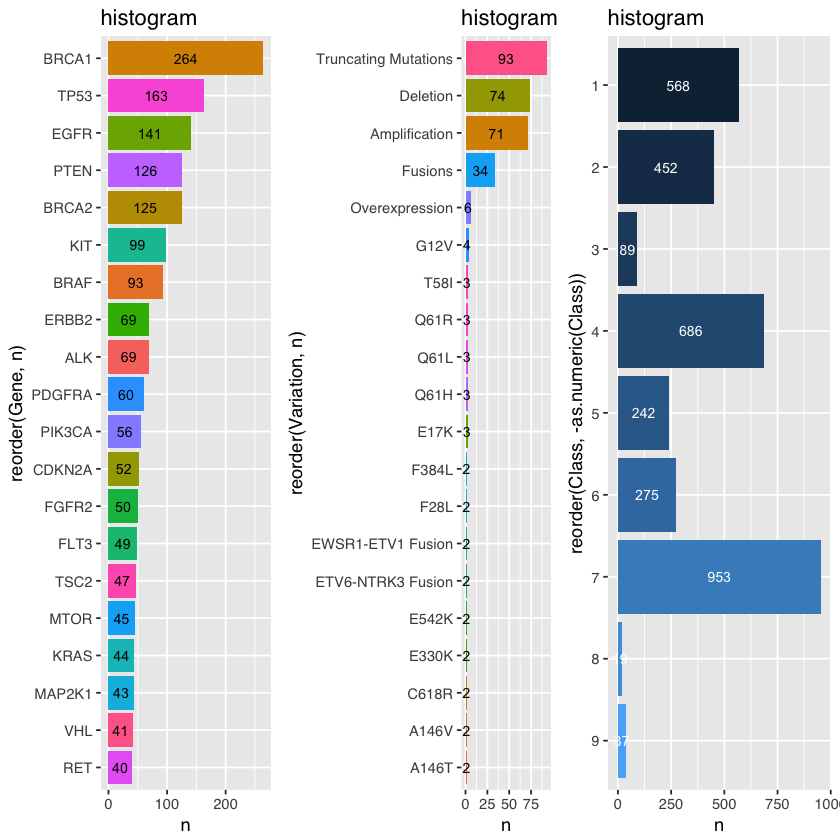

In [16]:
gene_freq <- trv %>% #check Gene frequency
  group_by(Gene) %>%
  count() %>%
  arrange(desc(n)) %>%
  head(n=20) %>%
  ggplot(aes(reorder(Gene, n),n , fill=Gene)) + 
  geom_col() + 
  geom_text(aes(label=n), size = 3, position = position_stack(vjust = 0.5)) +
  coord_flip() +
  theme_gray(base_family = "Helvetica") +
  theme(legend.position="none") + 
  labs(title="histogram")

var_freq <- trv %>% #check Variation frequency 
  group_by(Variation) %>%
  count() %>%
  arrange(desc(n)) %>%
  head(n=20) %>%
  ggplot(aes(reorder(Variation, n),n , fill=Variation)) + 
  geom_col() + 
  geom_text(aes(label=n), size = 3, position = position_stack(vjust = 0.5)) +
  coord_flip() +
  theme_gray(base_family = "Helvetica") +
  theme(legend.position="none") + 
  labs(title="histogram")

class_freq <- trv %>%
  group_by(Class) %>%
  count() %>%
  ggplot(aes(reorder(Class, -as.numeric(Class)),n , fill=Class)) + 
  geom_col() + 
  geom_text(aes(label=n), size = 3, color="white", position = position_stack(vjust = 0.5)) +
  coord_flip() +
  theme_gray(base_family = "Helvetica") +
  theme(legend.position="none") + 
  labs(title="histogram")

layout <- matrix(c(1,2,3),1,3,byrow=TRUE)
multiplot(gene_freq, var_freq, class_freq, layout=layout)

### #Findings
- In Gene feature, It shows not bad distribution compared with Variation. we can try to use it.
- In Variation feature, Almost classes are observed once or twice except few classes.
- In label(Class), we can check 3/8/9 class in detail while checking word & bigram  because those shows low frequency.
- The distribution of other classes seems not bad. (concetrated not too much to specific class)

<br><br>

### B. Gene/Variation frequency by Class
(used head(n=10) after sorting in descending order instead of top_n(10, n) because top_n() include all rows which have same frequency)
- top: Gene frequency distribution by Class
- bottom: Variation frequency distribution by Class

In [17]:
tr_10_gene <- trv %>%
  count(Gene) %>%
  arrange(desc(n)) %>%
  head(n=10) %>%
  mutate(div="tr")

te_10_gene <- tev %>%
  count(Gene) %>%
  arrange(desc(n)) %>%
  head(n=10) %>%
  mutate(div="te")

tr_10_var <- trv %>%
  count(Variation) %>%
  arrange(desc(n)) %>%
  head(n=10) %>%
  mutate(div="tr") 

te_10_var <- tev %>%
  count(Variation) %>%
  arrange(desc(n)) %>%
  head(n=10) %>%
  mutate(div="te")

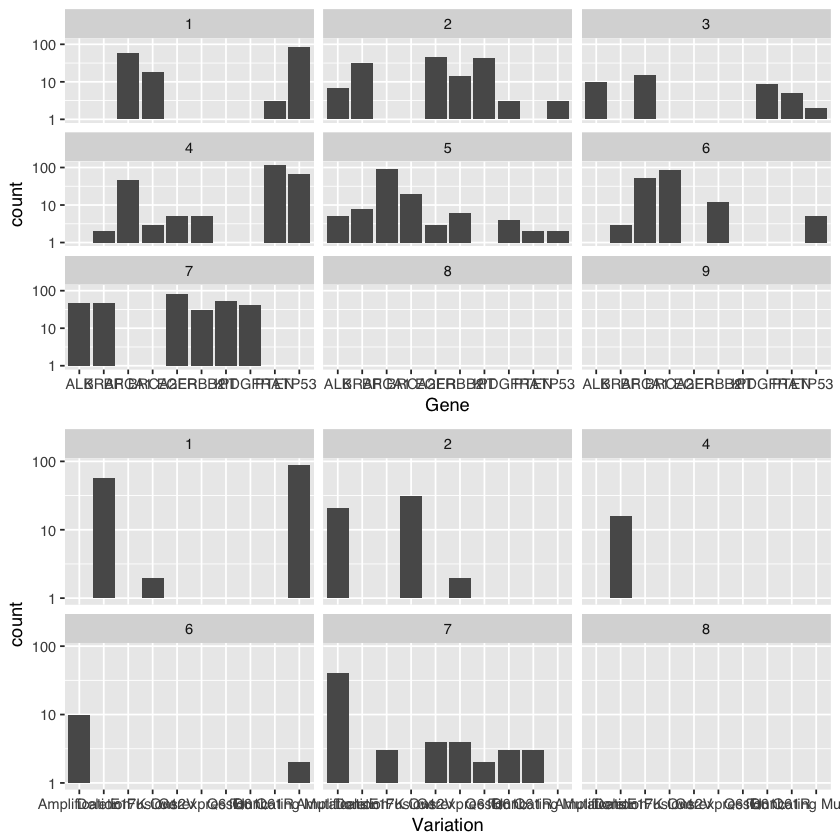

In [18]:
gene_tr_class <- trv %>%
  filter(Gene %in% as.character(tr_10_gene$Gene)) %>%
  ggplot(aes(Gene)) +
  geom_bar() +
  scale_y_log10() +
  theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=7)) +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class)

var_tr_class <- trv %>%
  filter(Variation %in% as.character(tr_10_var$Variation)) %>%
  ggplot(aes(Variation)) +
  geom_bar() +
  scale_y_log10() +
  theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=7)) +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~Class)

layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(gene_tr_class, var_tr_class)

### #Findings
- Class 3,5,9 are removed because they don't have a row include top 10 Variation class 
- Class distribution and Gene distribution seem to be quite different. However, looking at the previous class frequency graphs, there is a lack of observations.
- For example, 568 rows of the total training data are Class 1, but the sum of top 10 Gene and Variation for Class 1 is less than 300 each, which means if Gene or Variation of some rows are not in top 10 list, Those variables hardly help prediction of the remaining 300 rows.

<br><br>

### C. Gene/Variation frequency comparison of training & test set
(used head(n=10) after sorting in descending order instead of top_n(10, n) because top_n() include all rows which have same frequency)
- top: Gene frequency distribution comparison of training & test set
- bottom: Variation frequency distribution comparison of training & test set

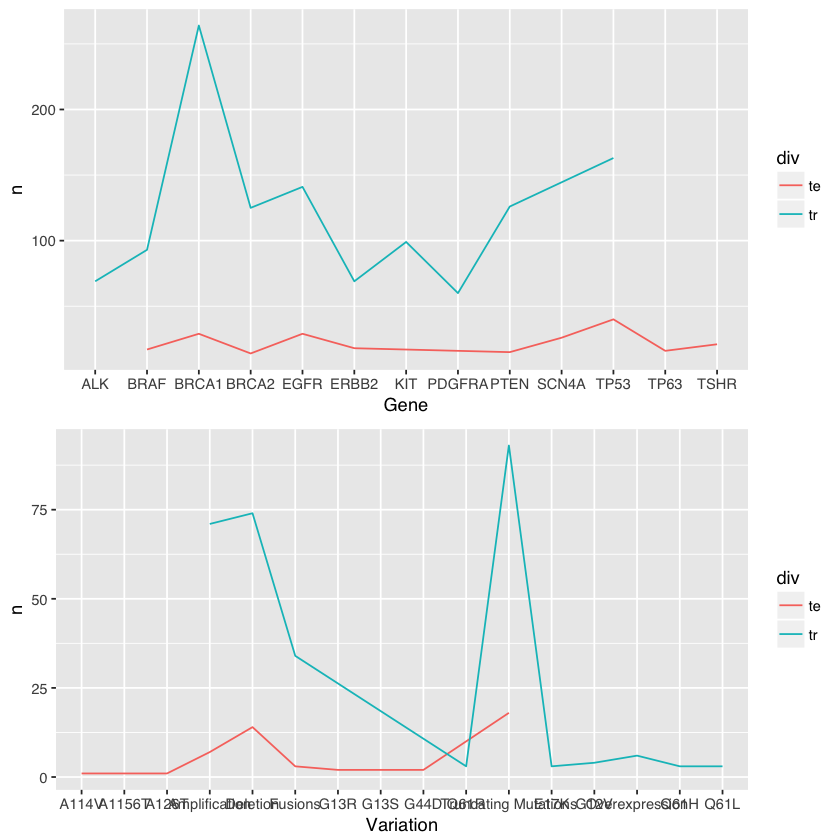

In [19]:
gene_compare <- data.frame(rbind(te_10_gene, tr_10_gene)) %>%
  ggplot(aes(x=Gene, y=n, group=div, fill=div, color=div)) + 
  geom_line() + 
  theme_gray(base_family = "Helvetica")

var_compare <- data.frame(rbind(te_10_var, tr_10_var)) %>%
  ggplot(aes(x=Variation, y=n, group=div, fill=div, color=div)) + 
  geom_line() +
  theme_gray(base_family = "Helvetica")

layout <- matrix(c(1,2),1,2,byrow=TRUE)
multiplot(gene_compare, var_compare)

### #Findings
- It is difficult to find similar patterns in the frequency distribution of training and test sets, which means that the results of training with training data may not be general-purpose expressive model to predict test data.
- Gene and Variation can be judged not to be informative variables in addition to the previous basic statistical analysis.

<hr>

## <a id='2.2'></a>2.2 Text data(1) - non-semantic : word/sentence/text length
Looking for features that can be extracted from text and do not have semantic information by checking the pattern of text length/number of words/number of sentences used in text.

### A. Null check
we can check there are 5 rows without description text in training set, while not in test set.

In [20]:
trxt %>%
  mutate(text_len=str_length(text)) %>%
  summary()

      ID                text              text_len     
 Length:3321        Length:3321        Min.   :     5  
 Class :character   Class :character   1st Qu.: 31338  
 Mode  :character   Mode  :character   Median : 46136  
                                       Mean   : 63618  
                                       3rd Qu.: 80156  
                                       Max.   :523395  

In [21]:
trxt %>%
  mutate(text_len=str_length(text)) %>%
  filter(text_len<=100) %>%
  select(ID, text, text_len)

ID,text,text_len
1109,null,5
1277,null,5
1407,null,5
1639,null,5
2755,null,5


In [22]:
trxt <- trxt %>%
  mutate(text_len=str_length(text)) %>%
  filter(text_len>100) %>%
  select(ID, text)

In [23]:
text %>%
  mutate(text_len=str_length(text)) %>%
  summary()

      ID                text              text_len     
 Length:986         Length:986         Min.   :   884  
 Class :character   Class :character   1st Qu.: 36885  
 Mode  :character   Mode  :character   Median : 52744  
                                       Mean   : 61208  
                                       3rd Qu.: 72780  
                                       Max.   :486731  

In [24]:
text %>%
  mutate(text_len=str_length(text)) %>%
  filter(text_len<=100) %>%
  select(ID, text, text_len)

ID,text,text_len


<br><br>

### B. Text length pattern by Class
- top : text length tendency by Class

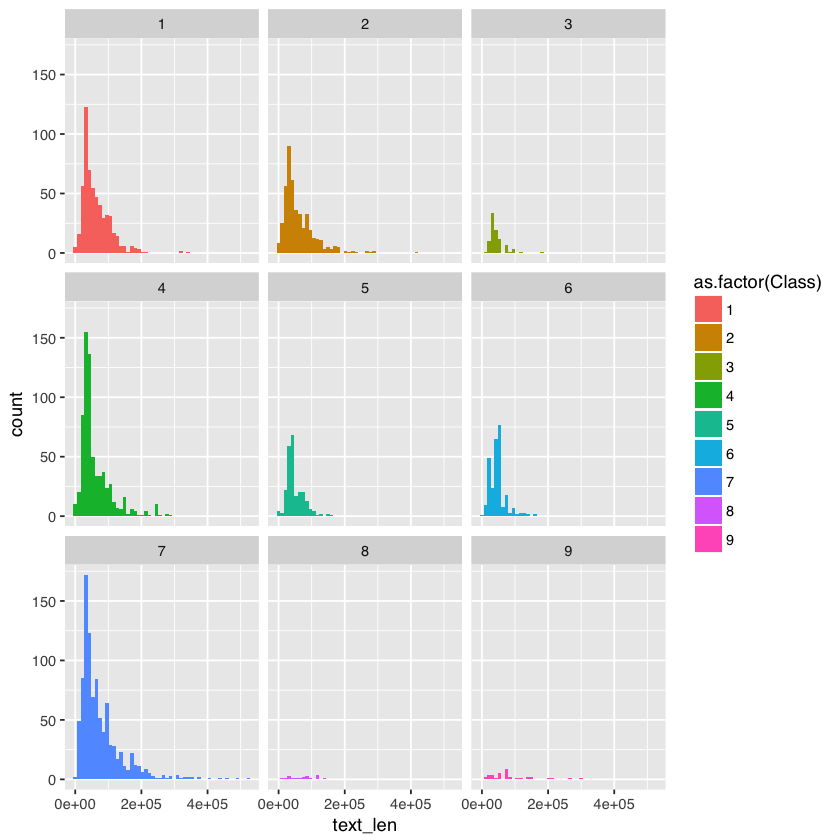

In [25]:
trxt %>%
  merge(trv, by="ID") %>%
  select(ID, text, Class) %>%
  mutate(text_len=str_length(text)) %>%
  ggplot(aes(text_len, fill=as.factor(Class))) +
  geom_histogram(bins=50) + 
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~Class)

### #Findings
- we can check that Class 1,4,7 has more quantitative information compared with other, especially Class 3,8,9.
- we already checked Class 3,8,9 has less frequency remarkablely than other.
- text_len can be meaningful variables to classify Class 3,8,9 and others.

<br><br>

### C. Pattern of text length, word_n, and sentence_n by Class & Correlation of 3
Visualize the average & distribution shape of text length, word_n, and sentence_n for each class using boxplot. In addition, it is intuitively obvious that the three variables have a high correlation, but it goes through the visualization surely.

- top : text length & number of words & number of sentences distribution with boxplot
- bottom : correlation matrix of text length & number of words & number of sentences

#### (data transformation - extracting word_n, sentence_n, and text_length from text)

In [26]:
word_n <- trxt %>%
  unnest_tokens(word, text, token="words") %>%
  count(ID) %>%
  mutate(word_n = n) %>%
  select(ID, word_n)

sentence_n <- trxt %>%
  unnest_tokens(sentence, text, token="sentences") %>%
  count(ID) %>%
  mutate(sentence_n = n) %>%
  select(ID, sentence_n)

tr_feature <- trv %>%
  merge(trxt, by="ID") %>%
  mutate(text_len = str_length(text)) %>%
  merge(word_n, by="ID") %>%
  merge(sentence_n, by="ID") %>%
  select(ID, Gene, Variation, text_len, word_n, sentence_n, Class)


feature_refining <- function(x, y){ 
  #x : trxt, text
  #y : trv, tev
  
  word_n <- x %>%
    unnest_tokens(word, text, token="words") %>%
    count(ID) %>%
    mutate(word_n = n) %>%
    select(ID, word_n)
  
  sentence_n <- x %>%
    unnest_tokens(sentence, text, token="sentences") %>%
    count(ID) %>%
    mutate(sentence_n = n) %>%
    select(ID, sentence_n)
  
  feature <- y %>%
    merge(x, by="ID") %>%
    mutate(text_len = str_length(text)) %>%
    merge(word_n, by="ID") %>%
    merge(sentence_n, by="ID") %>%
    select(ID, Gene, Variation, text_len, word_n, sentence_n)
  
  return(feature)
}

te_feature <- feature_refining(text, tev)

In [27]:
head(tr_feature)

ID,Gene,Variation,text_len,word_n,sentence_n,Class
0,FAM58A,Truncating Mutations,39673,6415,342,1
1,CBL,W802*,36692,6081,243,2
2,CBL,Q249E,36692,6081,243,2
3,CBL,N454D,36240,5708,184,3
4,CBL,L399V,41310,6422,266,4
5,CBL,V391I,41310,6422,266,4


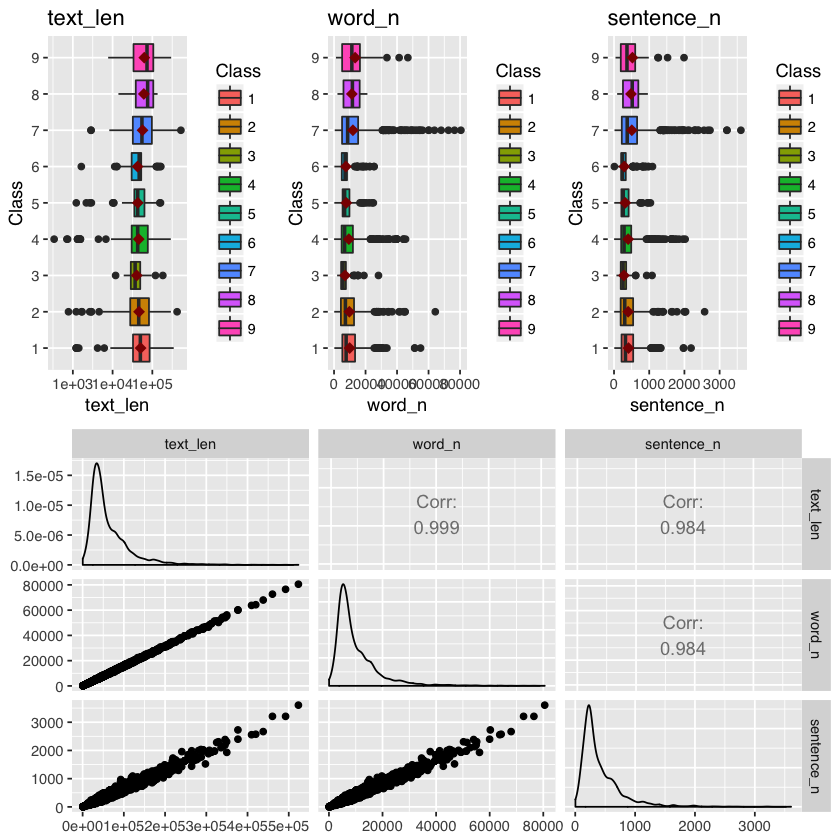

In [28]:
text_len_boxplot <- tr_feature %>%
  mutate(Class=as.factor(Class)) %>%
  ggplot(aes(Class, text_len, group=Class, fill=Class)) +
  geom_boxplot() +
  theme(legend.position="none") +
  scale_y_log10() + 
  coord_flip() + 
  stat_summary(fun.y=mean, colour="darkred", geom="point", shape=18, size=3, show.legend = FALSE) + 
  theme_gray(base_family = "Helvetica") +
  labs(title="text_len")

word_n_boxplot <- tr_feature %>%
  mutate(Class=as.factor(Class)) %>%
  ggplot(aes(Class, word_n, group=Class, fill=Class)) +
  geom_boxplot() +
  theme(legend.position="none") +
  coord_flip() + 
  stat_summary(fun.y=mean, colour="darkred", geom="point", shape=18, size=3, show.legend = FALSE) + 
  theme_gray(base_family = "Helvetica") +
  labs(title="word_n")

sentence_n_boxplot <- tr_feature %>%
  mutate(Class=as.factor(Class)) %>%
  ggplot(aes(Class, sentence_n, group=Class, fill=Class)) +
  geom_boxplot() +
  theme(legend.position="none") +
  coord_flip() + 
  stat_summary(fun.y=mean, colour="darkred", geom="point", shape=18, size=3, show.legend = FALSE) + 
  theme_gray(base_family = "Helvetica") +
  labs(title="sentence_n")

n_pairs <- tr_feature %>%
  select(text_len, word_n, sentence_n) %>%
  ggpairs() +
  theme_gray(base_family = "Helvetica")

layout <- matrix(c(1,2,3,4,4,4),2,3,byrow=TRUE)
multiplot(text_len_boxplot, word_n_boxplot, sentence_n_boxplot, n_pairs, layout=layout)

###  #Findings
- It also has very high correlation, as can be seen from the last pair plot.
- The distribution of text_len looks a little different, but it is a meaningless difference. (The difference of text_len is due to the difference in the length of the words used, but It can not be sure that long word does have more information than short word.)
- Therefore, only the word_n variable is used during the actual modeling.

<hr>

## <a id='2.3'></a>2.3 Text data(2) - semantic : word
A word can be regarded as the de facto minimum unit with semantic units. In Korean, Words are divided into morpheme units again. In English, however, stemmed (or lemmatized) words are considered as the minimum meaning unit.
The word analysis takes two steps: preprocessing steps such as stemming and elimination of stop words, and converting each word into numeric data.

In the first step, Divide the text into words, stemming, and look at the most commonly used words. Extract the top 20 words, the most commonly used words in the whole text. These top 20 words are likely to be stop words. Since the words are not informative in class distinction, They are removed with the stop word data provided by tidytext together.

In the second step, we use the word preprocessed in the first step. Create two sparse matrices with columns of stemmed words and rows of IDs. One has the observation of each word, and the other has the value of tf-idf of each word as value.

### A. Removing stop words
check out top 20 words of training & text data and list that tidytextR package offers, and remove stop words 
- top : distribution of top 20 words by Class

In [29]:
tr_word_token <- trxt %>% merge(trv, by="ID") %>%
  select(ID, text, Class) %>%
  unnest_tokens(word, text) %>%
  mutate(word=wordStem(word))

te_word_token <- text %>% 
  unnest_tokens(word, text) %>%
  mutate(word=wordStem(word))

top_word <- function(x, y){ #텍스트 데이터에서 y개의 top frequency 단어 추출
  temp <- x %>% 
    unnest_tokens(word, text, to_lower=TRUE) %>%
    mutate(word=wordStem(word)) %>%
    group_by(word) %>%
    count() %>%
    arrange(desc(n)) %>%
    head(n=y) %>%
    select(word, n)
  
  return(temp)
}
top_20_word <- top_word(trxt, 20)  
test_top_20 <- top_word(text, 20) %>% select(word) 

In [30]:
intersect(top_20_word$word, test_top_20$word)

[1] "the"   "of"    "and"   "in"    "a"     "to"    "with"  "mutat" "cell" 
[10] "that"  "for"   "were"  "i"     "by"    "wa"    "activ" "or"    "ar"   
[19] "on"    "1"

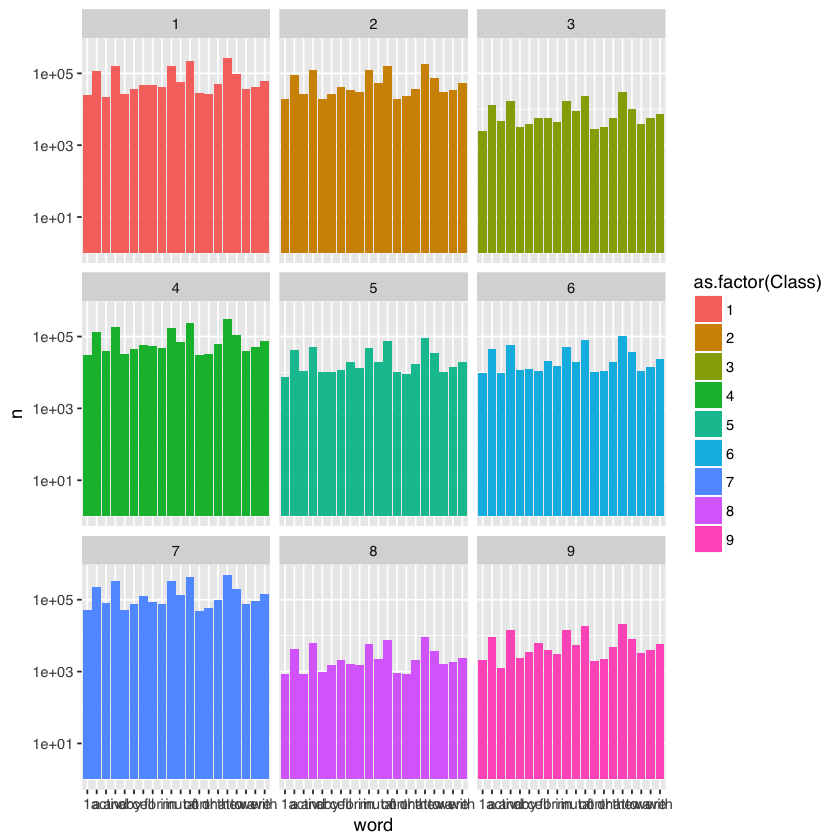

In [31]:
tr_word_token %>%
  filter(word %in% top_20_word$word) %>%
  count(Class, word) %>%
  ggplot(aes(x=word, y=n, fill=as.factor(Class))) +
  geom_bar(stat="identity") +
  scale_y_log10() +
  theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=7)) +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class)

In [32]:
data("stop_words")

In [33]:
head(stop_words$word, n=20)

[1] "a"           "a's"         "able"        "about"       "above"      
 [6] "according"   "accordingly" "across"      "actually"    "after"      
[11] "afterwards"  "again"       "against"     "ain't"       "all"        
[16] "allow"       "allows"      "almost"      "alone"       "along"

In [34]:
tr_word_token <-  tr_word_token %>% 
  filter(!word %in% top_20_word$word) %>%
  filter(!word %in% stop_words$word) 
#Let's remove top_20_word and stop_words at once.

### #Findings
- Both top 20 words of training and test set are same and those look like stop words such as "and", "the", "of" etc.
- Distributions of top 20 words per Class looks similar, so we'd better remove those top 20 words as well as stop words from tidytextR package.

<br><br>

### B. Removing uninformative words with tf-idf
A word with a low tfidf value is more likely to contain a relatively small amount of information when classifying a class. As the number of words increases, it becomes more difficult to effectively utilize computing resources. Therefore, it is necessary to check the class distribution of words with low tf-idf values and remove uninformative words.
- top : Distributions of words with low tf-idf value by Class

In [35]:
word_filter <- tr_word_token %>%
  count(ID, word) %>%
  bind_tf_idf(word, ID, n) %>%
  select(word, tf_idf) %>%
  unique() %>%
  arrange(tf_idf) %>% 
  select(word) %>%
  unique() %>%
  head(n=20)

In [36]:
word_filter$word

[1] "2"       "result"  "4"       "protein" "studi"   "5"       "report" 
 [8] "10"      "ha"      "sequenc" "includ"  "onli"    "gene"    "3"      
[15] "express" "indic"   "site"    "observ"  "effect"  "6"

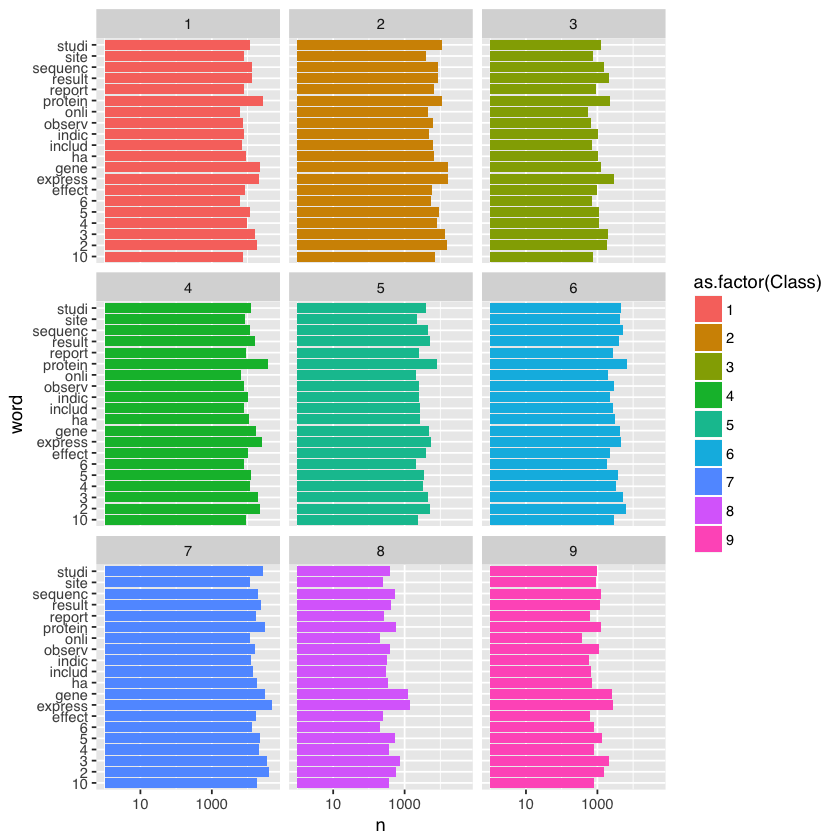

In [37]:
tr_word_token %>%
  filter(word %in% word_filter$word) %>%
  count(Class, word) %>%
  group_by(Class) %>%
  top_n(20, n) %>%
  ggplot(aes(x=word, y=n, fill=as.factor(Class))) +
  geom_bar(stat="identity") +
  scale_y_log10() +
  theme(axis.text.x  = element_text(angle=90, vjust=0.5, size=7)) +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class) +
  coord_flip()

### #Findings
- Words showing low tf_idf can be unsignificant because low tf_idf means that they are not discriminant factor.
- We can check distribution of filtered words are similar in all Class in graph.
- Class 3,8,9 show less frequency of those words than other because they have less frequecny and text_length as we know.
- Made these steps by function because we will use these 'word filter' as well as stop_words we used once in refining word of test set, and bigram visualization.

<br><br>

### C. Finding informative words by Class with word frequency
Check the distribution of the 20 most used words in each Class among the remaining words after the previous filtering.
- top : Distributions of top 20 words of each Class

In [38]:
class_word <- tr_word_token %>%
  filter(!word %in% word_filter$word) %>%
  count(Class, word) %>%
  arrange(Class, desc(n)) %>%
  group_by(Class) %>%
  top_n(20, n)

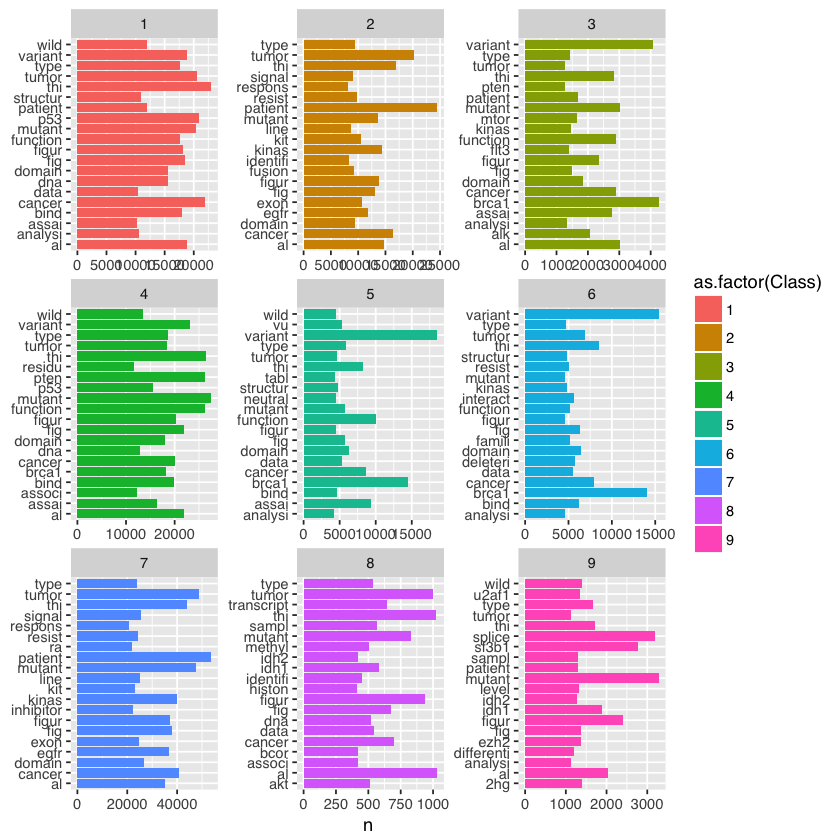

In [39]:
class_word %>%
  group_by(Class) %>% 
  top_n(20, n) %>%
  arrange(word) %>%
  ggplot(aes(word, n, fill = as.factor(Class))) +
  geom_col() +
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free") +
  coord_flip()

### # Findings
- Word set by Class seems quite different except some words such as "tumor", "variant" etc
- Those common words have different frequencies by Class, which mean that they can be discriminative variables in modeling.
- Below code shows different frequency of "tumor" by Class.

In [40]:
tr_word_token %>%
  count(ID, word) %>%
  filter(word=="tumor") %>%
  merge(trv, by="ID") %>%
  select(Class, word, n) %>%
  group_by(Class) %>%
  mutate(t_m = mean(n)) %>%
  select(Class, word, t_m) %>%
  unique()

Class,word,t_m
1,tumor,41.99180
2,tumor,53.35789
4,tumor,32.41506
7,tumor,54.52296
5,tumor,20.61333
9,tumor,30.67568
6,tumor,28.53086
8,tumor,55.50000
3,tumor,16.05063


<br><br>

### D. Finding informative words by Class with word tf-idf
We extracted top 20 words per each Class by their frequencies. below code is for extracted top 20 words per each Class by tf-idf.
- top : Distributions of words with top 20 tf-idf values of each Class

In [41]:
class_word_tf <- tr_word_token %>%
  filter(!word %in% word_filter$word) %>%
  count(ID, word) %>%
  bind_tf_idf(word, ID, n) %>%
  merge(trv, by="ID") %>%
  select(word, tf_idf, Class) %>%
  group_by(Class) %>%
  top_n(20, tf_idf) %>% 
  arrange(Class, desc(tf_idf))

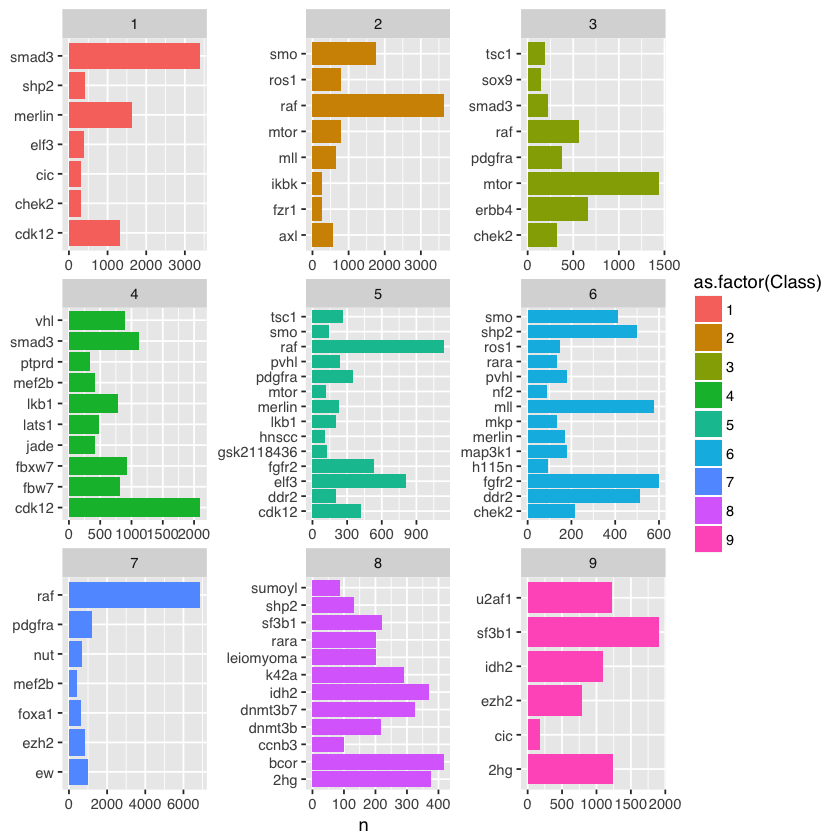

In [42]:
tr_word_token %>%
  filter(word %in% class_word_tf$word) %>%
  count(ID, word) %>%
  merge(trv, by="ID") %>%
  select(-ID, -Gene, -Variation) %>%
  group_by(Class) %>%
  top_n(20, n) %>%
  ungroup() %>%
  ggplot(aes(word, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free") +
  coord_flip()

### #Findings
- We can see that the factor set - extracted words and their distributions are quite different with the former (distributions of words extracted by frequencies).
- Let's keep both and check in validation stage, because there's not enough grounds to choose now.

<hr>

## <a id='2.4'></a>2.4 Text data(3) - semantic : bigram
Certain semantic information of text are involved in word analysis, but Information about the relationship between words are not. For example, "abnormal protein" and "normal protein" are contradictory contents, but Information about relationship of words such as "which adjective protein is connected" disappears while seperating text into words.<br>
The information about the relationship between these words can be important information in understanding the context of the actual text and classifying Class. By analyzing bigram by grouping it in units of two words, it can prevent this kind of information loss to some extent.

### A. Removing stop words
The bigram analysis also begins with removing the abbreviations with the previous filters and then combining them again into bigram.

In [43]:
tr_bigram_token <- trxt %>% 
  select(ID, text) %>% 
  unnest_tokens(bigram, text, token = "ngrams", n = 2) %>%
  separate(bigram, c('w1','w2'), sep=" ") %>%
  mutate(w1=wordStem(w1)) %>%
  mutate(w2=wordStem(w2)) %>%
  filter(!w1 %in% stop_words$word) %>%
  filter(!w2 %in% stop_words$word) %>%
  filter(!w1 %in% top_20_word$word) %>%
  filter(!w2 %in% top_20_word$word) %>%
  unite(bigram, w1, w2, sep=" ")

#### below graph shows the bigram distribution by class without additional filtering after top20word filter & tidytext stopword filter.
- top : Distributions of bigrams by Class with free scales (show only observed bigrams in each Class)
- bottom : Distributions of bigrams by Class with fixed scales (show all bigrams if observed even in one Class)

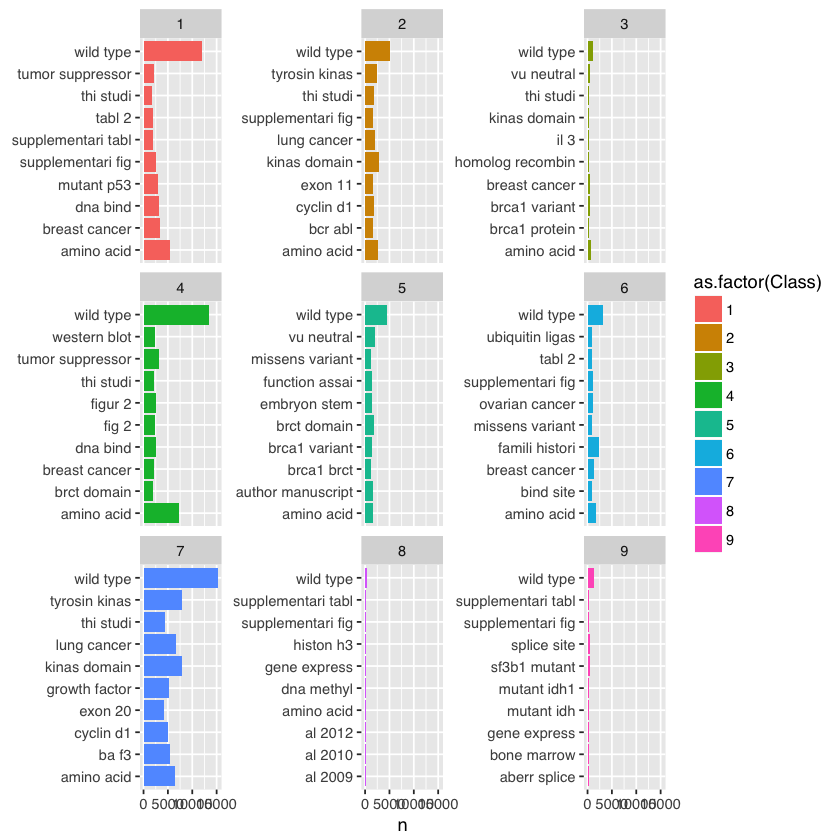

In [44]:
tr_bigram_token %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation) %>%
  count(Class, bigram) %>%
  group_by(Class) %>%
  top_n(10, n) %>%
  ungroup() %>%
  ggplot(aes(bigram, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free_y") +
  coord_flip()

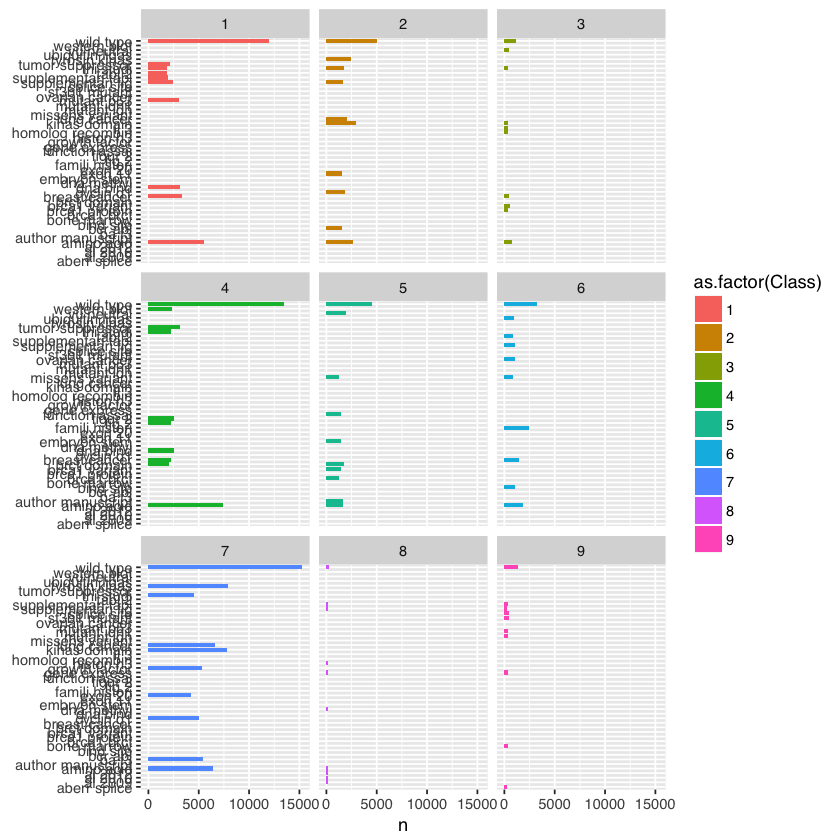

In [45]:
tr_bigram_token %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation) %>%
  count(Class, bigram) %>%
  group_by(Class) %>%
  top_n(10, n) %>%
  ungroup() %>%
  ggplot(aes(bigram, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="fixed") +
  coord_flip()

### #Findings
- The fixed scale makes it difficult to see detailed words, but the class-specific differences appear more clearly.
- The bigram, which is often observed by class, is different, and the detailed distribution is also different.
- Above all, Class 8 and Class 9, which showed similar patterns so far, are clearly distinguished.
- (it may be good enough for now) To improve accuracy by eliminating words observed in every Classes, such as wild type, but It'd be better to check if we can make additional filter(bigram_filter) like the word_filter we created earlier.

<br><br>

### B. Checking whether to use bigram_filter
Bigram_filter is bigram list which contain bigrams showing low tf-idf value. Below graph shows frequency of bigram in bigram_filter by Class to see bigram_filter is useful filter. If distribution seems similar regardless of Class, We can guess that the filter is useful.

- top : Distributions of bigram in bigram_filter by Class
- bottom : Distributions of bigram by Class after filtering

#### * below code is for making bigram_filter as we made word_filter.

In [46]:
bigram_filter <- tr_bigram_token %>%
  count(ID, bigram) %>%
  bind_tf_idf(bigram, ID, n) %>%
  select(bigram, tf_idf) %>%
  unique() %>%
  arrange(tf_idf) %>% 
  select(bigram) %>%
  unique() %>%
  head(n=15)

In [47]:
bigram_filter$bigram

[1] "wild type"        "amino acid"       "figur 3"          "figur 2"         
 [5] "figur 4"          "thi studi"        "bind domain"      "acid substitut"  
 [9] "express level"    "fig 1a"           "fig 1b"           "tumor suppressor"
[13] "breast cancer"    "western blot"     "express vector"

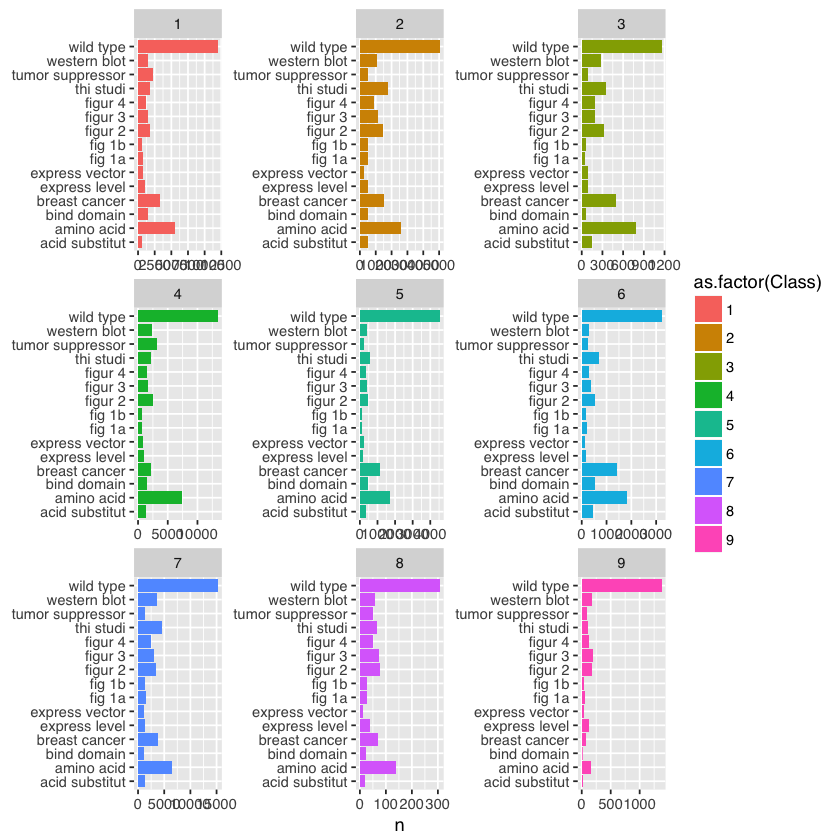

In [48]:
tr_bigram_token %>%
  filter(bigram %in% bigram_filter$bigram) %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation) %>%
  count(Class, bigram) %>%
  ggplot(aes(bigram, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free") +
  coord_flip()

In [49]:
options(warn=-1) #Turn off and on the error message for a moment because there is an error caused by the font problem.

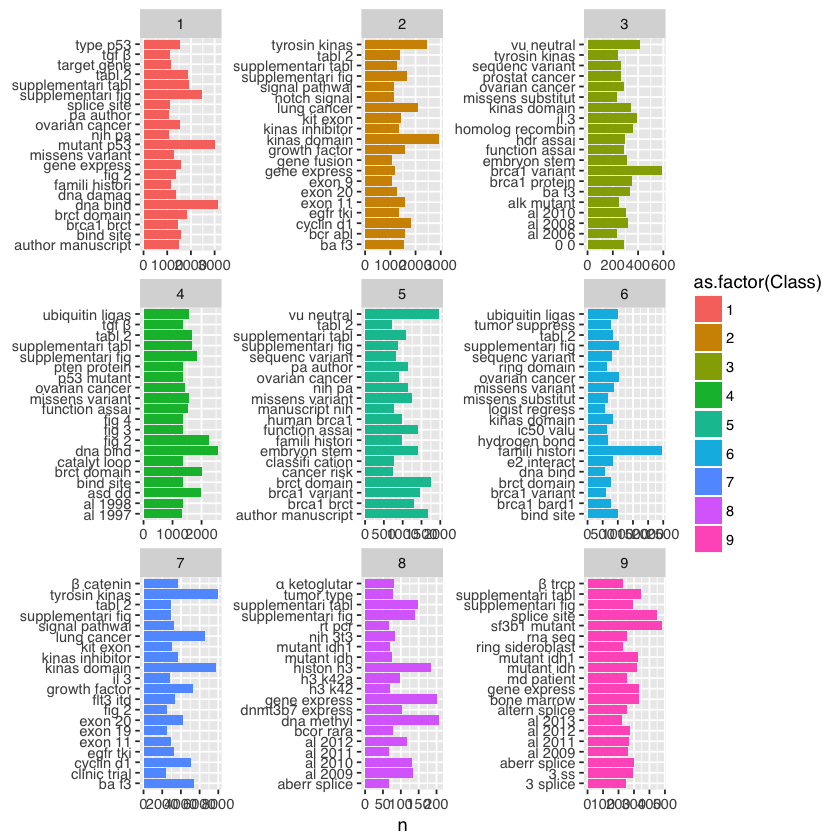

In [50]:
tr_bigram_token %>%
  filter(!bigram %in% bigram_filter$bigram) %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation) %>%
  count(Class, bigram) %>%
  group_by(Class) %>%
  top_n(20, n) %>%
  ungroup() %>%
  ggplot(aes(bigram, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free") +
  coord_flip()

In [51]:
options(warn=0)

### #Findings
- If you look at scales="free", It can be confirmed that the bigram set per class is different. In other words, bigram_filter is more likely to be a useful filter. The factor sets are quite mutually exclusive. We can try modeling with this bigram set.
- If you look at scales="fixed", you can see that frequency is obviously different. However, this is basically due to frequency of Class. (Higher classes are higher, 1, 4, and 7, while others are lower.)
- One concern is that the observation frequency (n) of some bigrams is low. For example, if the frequency of "atrx loss" is at most 200 while the frequency of Class 1 is 568, there is a high probability that there will be no bigram in actual prediction even if pattern is collected from training data.
- In this case, since the factor set is sufficiently mutually exclusive, the probability that the text which includes any bigram of each Class is correctly classified gets higher. Otherwise (the case which text does not include bigram), We need to consider how to construct a feature set by mixing bigram and word to increase the probability of being correctly classified.

#### * The following is the result of using bigram to split back into words, then to word_filter and rejoin.

In [52]:
#below 'tbt_fted' is filtered using word_filter (seperate bigram, filter w1, w2 with word_filter we made once, and unite to bigram again)
tbt_fted <- tr_bigram_token %>%
  separate(bigram, c("w1","w2"), sep=" ") %>%
  filter(!w1 %in% word_filter$word) %>%
  filter(!w2 %in% word_filter$word) %>%
  unite(bigram, w1, w2, sep=" ")

In [53]:
options(warn=-1)

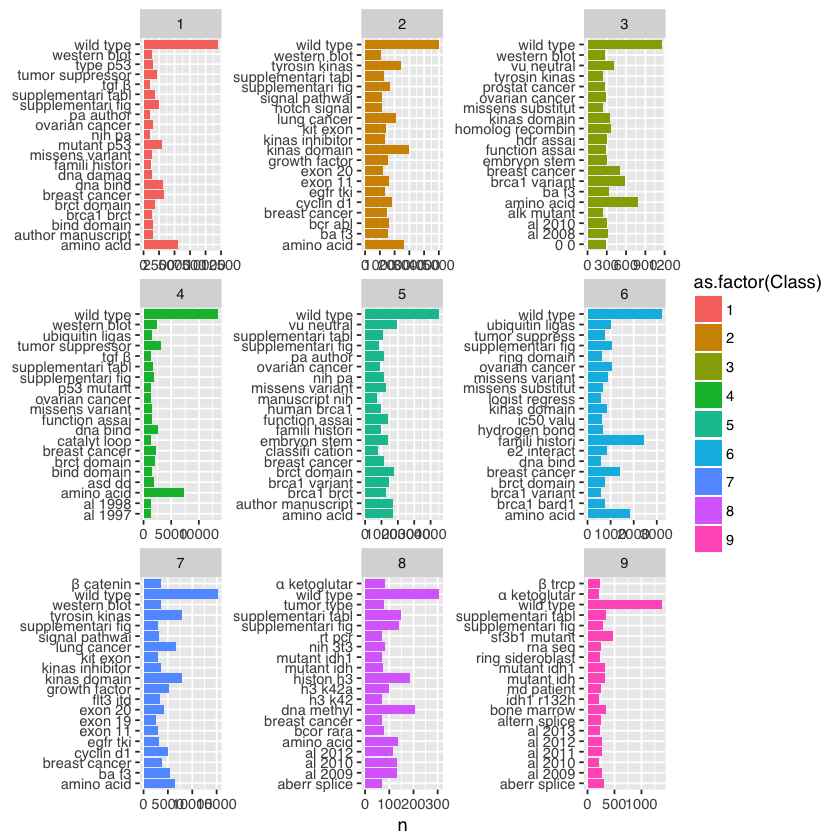

In [54]:
tbt_fted %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation) %>%
  count(Class, bigram) %>%
  group_by(Class) %>%
  top_n(20, n) %>%
  ungroup() %>%
  ggplot(aes(bigram, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free") +
  coord_flip()

In [55]:
options(warn=0)

### #Findings
- In fact, the factor set filtered by word_filter is sufficiently mutually exclusive and has a decent pattern.
- However, When word_filter is used, all words such as "mutant", "cell" disappear. In other words, the information of word such as "mutant" or "cell" all disappear from both the word feature and the bigram feature.
- If you use only the word feature or bigram feature filtered with word_filter, the word "mutant" itself will be removed because it is likely to be a frequently observed word in all classes.
- In the form of bigram, there may be cases that the common word became significant information after combining with another word, for example, unsignificat word "mutant became informative bigram "sf3b1 mutant" in Class 9 after combining with "sf3b1".
#### -> We will use "bigram_filter" only in this analysis.

<br><br>

### C. Finding informative bigram by Class with frequency & bigram tf-idf
As before we extracted top 20 words per each Class by their frequencies & word tf-idf, below code is for extracted top 20 bigrams per each Class by frequency & bigram tf-idf.

#### * Extracting top 20 bigrams per each Class by their frequencies.

In [56]:
tr_bigram_token <- tr_bigram_token %>%
  filter(!bigram %in% bigram_filter$bigram)

In [57]:
class_bigram <- tr_bigram_token %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation, -ID) %>%
  count(Class, bigram) %>%
  distinct(Class, bigram, .keep_all=TRUE) %>%
  group_by(Class) %>%
  top_n(20, n) %>%
  arrange(Class, desc(n))

#### * Extracting top 20 bigrams per each Class by bigram tf_idf.

In [58]:
class_bigram_tf <- tr_bigram_token %>%
  merge(trv, by="ID") %>%
  select(ID, bigram, Class) %>%
  count(Class, bigram) %>%
  bind_tf_idf(bigram, Class, n) %>%
  select(bigram, tf_idf, Class) %>%
  distinct(Class, bigram, .keep_all=TRUE) %>%
  group_by(Class) %>%
  top_n(20, tf_idf) %>%
  arrange(Class, desc(tf_idf))

In [59]:
options(warn=-1)

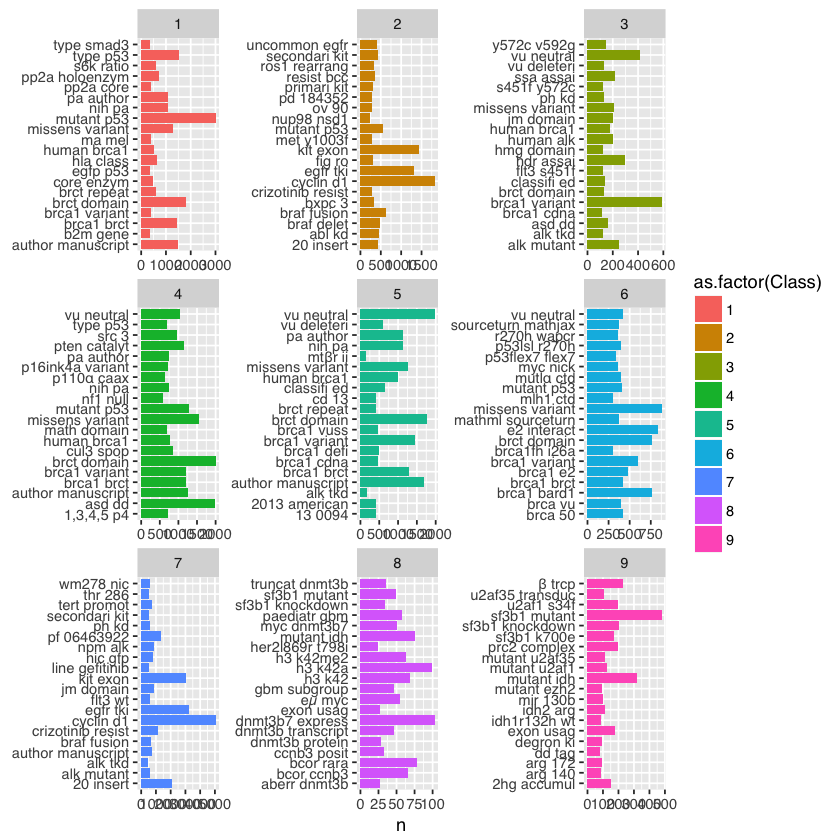

In [60]:
tr_bigram_token %>%
  filter(bigram %in% class_bigram_tf$bigram) %>%
  merge(trv, by="ID") %>%
  select(-Gene, -Variation) %>%
  count(Class, bigram) %>% 
  group_by(Class) %>%
  top_n(20, n) %>%
  ungroup() %>%
  ggplot(aes(bigram, n, fill=as.factor(Class))) +
  geom_col() + 
  labs(x = NULL, y = "n") +
  theme(legend.position = "none") +
  theme_gray(base_family = "Helvetica") +
  facet_wrap(~ Class, ncol=3, scales="free") +
  coord_flip()

In [61]:
options(warn=0)

### # Findings
- We can see that the factor set - extracted bigrams and their frequencies are quite different with the former.
- Let's keep both and check in validation stage, because there's not enough grounds to choose now.

#### * Truncating rows with more than 20 features per class with the same frequency or tf-idf value

In [62]:
trunc_feature <- function(x){
  temp <- head(x, n=0)
  names(temp) <- names(x)
  
  for(i in c(1:9)){
    c <- x %>%
      filter(Class==i)
    if(nrow(c)>20){
      c <- head(c, n=20)
    }
    
    temp <- rbind(temp, c)
  }
  return(temp)
}

class_word <- trunc_feature(class_word)
class_word_tf <- trunc_feature(class_word_tf)
class_bigram <- trunc_feature(class_bigram)
class_bigram_tf <- trunc_feature(class_bigram_tf)

<br><hr><br>

# <a id='3'></a>3. Xgboost model

- 3.1 Data preprocessing
- 3.2 Defining functions for model
- 3.3 Varing input variables (word/bigram, n/tf-idf) & Result comparison

<hr>

## <a id='3.1'></a>3.1 Data preprocessing

We will preprocess the data for use in xgboost reflecting the insights gained through previous visualization. The data will be transformed to the shape to make it easier to get the results we want using functions created with the xgboost library.<br>

In [63]:
#training set을 tr과 valid set으로 나눠서 작성해본다. 
set.seed(180302)
sam_num <- sample(nrow(trv), 2200)
ID_list <- sort(unique(trv$ID))
tr_num <- ID_list[sam_num]
te_num <- ID_list[-sam_num]

In [64]:
tr_word_data <- tr_word_token %>%
  filter(ID %in% tr_num) %>%
  count(ID, word) %>%
  merge(trv, by="ID") %>%
  select(ID, word, n, Class)

te_word_data <- tr_word_token %>%
  filter(ID %in% te_num) %>%
  count(ID, word) %>%
  merge(trv, by="ID") %>%
  select(ID, word, n)

te_word_label <- tr_word_token %>%
  filter(ID %in% te_num) %>%
  select(ID, Class) %>%
  mutate(ID=as.numeric(ID)) %>%
  arrange(ID) %>%
  distinct()

In [65]:
tr_bigram_data <- tr_bigram_token %>%
  filter(ID %in% tr_num) %>%
  count(ID, bigram) %>%
  merge(trv, by="ID") %>%
  select(ID, bigram, n, Class)

te_bigram_data <- tr_bigram_token %>%
  filter(ID %in% te_num) %>%
  count(ID, bigram) %>%
  merge(trv, by="ID") %>%
  select(ID, bigram, n)
  

te_bigram_label <- tr_bigram_token %>%
  filter(ID %in% te_num) %>%
  merge(trv, by="ID") %>%
  select(ID, bigram, Class) %>%
  select(ID, Class) %>%
  mutate(ID=as.numeric(ID)) %>%
  arrange(ID) %>%
  distinct()

<hr>

## <a id='3.2'></a>3.2 Defining functions for model

These functions are for modifying the input variables according to the word/bi-gram and frequency/tf-idf for models,  and examining the results of those models in the form of a table.
<br>

In [66]:
#주어진 변수를 이용해 각 ID별 i번째 클래스의 feature를 가진 frequency table로 만듬
freq_table <- function(feature=x, data=y, by=z, token=w, i=i, pur=k){
  #feature : class_word처럼 분류할 label별 word 혹은 bigram 등
  #data : tr_word_token처럼 document(ID)별 tokenized된 word와 bigram 목록과 label
  #by : frequency 기준일지, tf-idf를 이용할 것인지
  #token : word를 이용할 것인지, bigram을 이용할 것인지
  
  feature <- feature %>% #i번째 label에 해당하는 feature set만 유지
    filter(Class==i)
  
  if(pur=="train"){
    data <- data %>% 
      filter(Class==i) #i번째 label에 해당하는 행만 유지
  }
  
  if(token=="word"){
    if(by=="tf_idf"){
      feature <- feature %>%
        mutate(n=tf_idf) %>%
        select(-tf_idf)
      
      data <- data %>%
        bind_tf_idf(word, ID, n) %>%
        select(-n, -tf, -idf) %>%
        mutate(n=tf_idf) %>%
        select(-tf_idf)
    }
    
    crs_join <- merge(unique(data %>% select(ID)), feature$word, by=NULL) %>%
      mutate(word=y) %>%
      select(-y) %>%
      arrange(as.numeric(ID))
    
    ft_vec <- as.character(unique(feature$word))
    
    data <- data %>%
      filter(word %in% ft_vec)
    
    if(pur=="train"){
      data <- data %>%
        select(-Class) }
    
    lft_join <- merge(crs_join, data, all.x="TRUE") %>%
      arrange(as.numeric(ID))
    lft_join[is.na(lft_join)] <- 0
    lft_join <- lft_join %>% unique() 
    
    tab <- dcast(lft_join, ID~word, value.var="n", fill=0) %>%
      arrange(as.numeric(ID))
  } 
  if(token=="bigram"){
    if(by=="tf_idf"){
      feature <- feature %>%
        mutate(n=tf_idf) %>%
        select(-tf_idf)
      
      data <- data %>%
        bind_tf_idf(bigram, ID, n) %>%
        select(-n, -tf, -idf) %>%
        mutate(n=tf_idf) %>%
        select(-tf_idf)
    }
    
    crs_join <- merge(unique(data %>% select(ID)), feature$bigram, by=NULL) %>%
      mutate(bigram=y) %>%
      select(-y) %>%
      arrange(as.numeric(ID))
    
    ft_vec <- as.character(t(feature$bigram))
    
    data <- data %>%
      filter(bigram %in% ft_vec)
    
    if(pur=="train"){
      data <- data %>%
        select(-Class) }
    
    lft_join <- merge(crs_join, data, all.x="TRUE") %>%
      arrange(as.numeric(ID))
    lft_join[is.na(lft_join)] <- 0
    
    tab <- dcast(lft_join, ID~bigram, value.var="n", fill=0) %>%
      arrange(as.numeric(ID))
  }
  
  return(tab)
}

In [67]:
#주어진 frequency table을 이용해 i번째 클래스의 feature별 관측 probability table로 만듬
prob_mat <- function(freq_tab=x){
  den <- freq_tab %>%
    select(-ID) %>%
    sum()
  
  num <- freq_tab %>%
    select(-ID) %>%
    apply(2, sum)
  aa <- (num+1)/(den+length(num))
  return(matrix(aa))
}

In [68]:
softmax <- function(x){
  return(exp(x+max(x))/sum(exp(x+max(x))))
}

In [69]:
onehot_gene <- function(x, n){
  aa <- trv %>%
    count(Gene) %>%
    arrange(desc(n)) %>%
    top_n(30, n)
  
  qq <- data.frame(cbind(with(x, model.matrix(~Gene + 0))))
  names(qq) <- sub("Gene", "", names(qq))
  qq <- qq %>%
    select(names(qq)[names(qq) %in% intersect(names(qq), aa$Gene)])
  
  return(qq)
}

In [70]:
##multi-class xgboost
multi_xgboost <- function(feature=feature, tr_data=tr_data, te_data=te_data, by=by, token=token, params=param){
  #feature=class_word; tr_data=tr_word_data; te_data=te_word_data; by="n"; token="word"; params=param
  tr_dcg <- data.frame(sort(as.numeric(unique(tr_data$ID))))
  names(tr_dcg) <- "ID"
  te_dcg <- data.frame(sort(as.numeric(unique(te_data$ID))))
  names(te_dcg) <- "ID"
  
  for(i in c(1:9)){
    trn <- freq_table(feature=feature, data=tr_data, by=by, token=token, i=i, pur="test")
    tes <- freq_table(feature=feature, data=te_data, by=by, token=token, i=i, pur="test")
    
    trn <- trn %>% select(names(trn)[!names(trn) %in% intersect(names(tr_dcg), names(trn))])
    tes <- tes %>% select(names(tes)[!names(tes) %in% intersect(names(te_dcg), names(tes))])
    
    tr_dcg <- data.frame(cbind(tr_dcg, trn))
    te_dcg <- data.frame(cbind(te_dcg, tes))
  }
  
  tr_len <- trxt %>%
    mutate(text_len=log10(str_length(text))) %>%
    select(ID, text_len)
  
  te_len <- text %>%
    mutate(text_len=log10(str_length(text))) %>%
    select(ID, text_len)
  
  trv_temp <- trv %>%
                filter(ID %in% tr_len$ID)

  tr_gene <- onehot_gene(trv_temp, 30)
  te_gene <- onehot_gene(tev, 30)
  
  tr_dcg <- tr_dcg %>% 
    merge(data.frame(cbind(tr_len, tr_gene)), by="ID")
  
  te_dcg <- te_dcg %>% 
    merge(data.frame(cbind(tr_len, tr_gene)), by="ID")
  
  
  tr_dcg <- tr_dcg %>%
    merge(trv, by="ID") %>%
    select(-Gene, -Variation) %>%
    mutate(ID=as.numeric(ID)) %>%
    arrange(ID)
  
  trn_lab <- tr_dcg$Class-1
  trn_data <- as(as.matrix(tr_dcg %>% select(-ID, -Class)), "dgCMatrix")
  
  trn_matrix <- xgb.DMatrix(data=trn_data, label=trn_lab)
  tes_data <- as(as.matrix(te_dcg %>% select(-ID)), "dgCMatrix")
  
  #cv.res <- xgb.cv(params=param, data=trn_matrix, nfold=5, early_stopping_rounds=3, nrounds=30)
  model <- xgboost(data=trn_matrix, nrounds=100, params=param, verbose=1)
  xgb_temp <- predict(model, tes_data)
  xgb_result <- matrix(xgb_temp, nrow = 9, ncol=length(xgb_temp)/9)
  xgb_result <- data.frame(cbind(te_dcg$ID, t(xgb_result)))
  names(xgb_result) <- c("ID", c(1:9))
  
  return(xgb_result)
}

In [71]:
#checking the result with validation set
max_class <- function(x){
  temp_id <- x[,1]
  temp <- apply(x[,-1], 1, function(y){ return(names(y)[which(y==max(y))][1]) })
  temp <- data.frame(cbind(temp_id, unlist(temp)))
  names(temp) <- c("ID","Class")
  
  return(temp)
}

In [72]:
result_table <- function(pred_result, te_label){
  res <- max_class(pred_result)
  res$Class <- factor(res$Class, levels = c(1:9))
  print(table(res$Class, te_label$Class, dnn=c("predicted","actual")))
  print(table(res$Class==te_label$Class))
  
  result_table <- data.frame(as.matrix(table(res$Class, te_label$Class, dnn=c("predicted","actual")), ncol=9))
  res$Class
  precision_recall <- result_table %>%
    group_by(predicted) %>%
    mutate(pre_sum=sum(Freq)) %>%
    ungroup() %>%
    group_by(actual) %>%
    mutate(act_sum=sum(Freq)) %>%
    ungroup() %>%
    filter(predicted==actual) %>%
    mutate(precision=Freq/pre_sum) %>%
    mutate(recall=Freq/act_sum) %>%
    mutate(Class=actual) %>%
    select(Class, precision, recall)
  
  #print(precision_recall)
  
  return(precision_recall)
}

<hr>

## <a id='3.3'></a>3.3 Varing input variables (word/bigram, n/tf-idf)<br>

In [73]:
result_compare <- data.frame(cbind(c(1:9),matrix(nrow=9,ncol=0)))

In [74]:
param <- list(objective = "multi:softprob",
              eval_metric = "mlogloss",
              num_class = 9,
              max_depth = 20,
              eta = 0.05,
              gamma = 0.01, 
              subsample = 0.9)

In [75]:
#model using word & n
xgb_result <- multi_xgboost(feature=class_word, tr_data=tr_word_data, te_data=te_word_data, by="n", token="word", params=param)
temp <- result_table(xgb_result, te_word_label) #accuracy : 0.6244
result_compare <- cbind(result_compare, temp[,-1])

[1]	train-mlogloss:2.080941 
[2]	train-mlogloss:1.976504 
[3]	train-mlogloss:1.881297 
[4]	train-mlogloss:1.793730 
[5]	train-mlogloss:1.714710 
[6]	train-mlogloss:1.640717 
[7]	train-mlogloss:1.573084 
[8]	train-mlogloss:1.509436 
[9]	train-mlogloss:1.448837 
[10]	train-mlogloss:1.392431 
[11]	train-mlogloss:1.340014 
[12]	train-mlogloss:1.289870 
[13]	train-mlogloss:1.243062 
[14]	train-mlogloss:1.199294 
[15]	train-mlogloss:1.158137 
[16]	train-mlogloss:1.118503 
[17]	train-mlogloss:1.081029 
[18]	train-mlogloss:1.045821 
[19]	train-mlogloss:1.012190 
[20]	train-mlogloss:0.979949 
[21]	train-mlogloss:0.949221 
[22]	train-mlogloss:0.919814 
[23]	train-mlogloss:0.892069 
[24]	train-mlogloss:0.865227 
[25]	train-mlogloss:0.840373 
[26]	train-mlogloss:0.816089 
[27]	train-mlogloss:0.792833 
[28]	train-mlogloss:0.770914 
[29]	train-mlogloss:0.749847 
[30]	train-mlogloss:0.729605 
[31]	train-mlogloss:0.710581 
[32]	train-mlogloss:0.692277 
[33]	train-mlogloss:0.674514 
[34]	train-mlogloss

In [76]:
#model using word & tf_idf
xgb_result <- multi_xgboost(feature=class_word_tf, tr_data=tr_word_data, te_data=te_word_data, by="tf_idf", token="word", params=param)
temp <- result_table(xgb_result, te_word_label) #accuracy : 0.5432
result_compare <- cbind(result_compare, temp[,-1])

[1]	train-mlogloss:2.116445 
[2]	train-mlogloss:2.042273 
[3]	train-mlogloss:1.975186 
[4]	train-mlogloss:1.914243 
[5]	train-mlogloss:1.857848 
[6]	train-mlogloss:1.805168 
[7]	train-mlogloss:1.756723 
[8]	train-mlogloss:1.709537 
[9]	train-mlogloss:1.667960 
[10]	train-mlogloss:1.626990 
[11]	train-mlogloss:1.590596 
[12]	train-mlogloss:1.554980 
[13]	train-mlogloss:1.522150 
[14]	train-mlogloss:1.488978 
[15]	train-mlogloss:1.458431 
[16]	train-mlogloss:1.428632 
[17]	train-mlogloss:1.401262 
[18]	train-mlogloss:1.373490 
[19]	train-mlogloss:1.348140 
[20]	train-mlogloss:1.324081 
[21]	train-mlogloss:1.301468 
[22]	train-mlogloss:1.279625 
[23]	train-mlogloss:1.257474 
[24]	train-mlogloss:1.236802 
[25]	train-mlogloss:1.216792 
[26]	train-mlogloss:1.196602 
[27]	train-mlogloss:1.178219 
[28]	train-mlogloss:1.161348 
[29]	train-mlogloss:1.144145 
[30]	train-mlogloss:1.128030 
[31]	train-mlogloss:1.111912 
[32]	train-mlogloss:1.096659 
[33]	train-mlogloss:1.082518 
[34]	train-mlogloss

In [77]:
#model using bigram & n
xgb_result <- multi_xgboost(feature=class_bigram, tr_data=tr_bigram_data, te_data=te_bigram_data, by="n", token="bigram", params=param)
temp <- result_table(xgb_result, te_bigram_label) #accuracy : 0.6146
result_compare <- cbind(result_compare, temp[,-1])

[1]	train-mlogloss:2.088679 
[2]	train-mlogloss:1.990649 
[3]	train-mlogloss:1.901628 
[4]	train-mlogloss:1.820037 
[5]	train-mlogloss:1.745136 
[6]	train-mlogloss:1.675969 
[7]	train-mlogloss:1.612749 
[8]	train-mlogloss:1.553773 
[9]	train-mlogloss:1.497586 
[10]	train-mlogloss:1.445364 
[11]	train-mlogloss:1.396055 
[12]	train-mlogloss:1.348762 
[13]	train-mlogloss:1.305199 
[14]	train-mlogloss:1.263151 
[15]	train-mlogloss:1.223372 
[16]	train-mlogloss:1.184779 
[17]	train-mlogloss:1.148580 
[18]	train-mlogloss:1.114949 
[19]	train-mlogloss:1.081810 
[20]	train-mlogloss:1.050743 
[21]	train-mlogloss:1.020664 
[22]	train-mlogloss:0.991834 
[23]	train-mlogloss:0.965029 
[24]	train-mlogloss:0.939207 
[25]	train-mlogloss:0.913481 
[26]	train-mlogloss:0.889047 
[27]	train-mlogloss:0.865453 
[28]	train-mlogloss:0.842740 
[29]	train-mlogloss:0.821649 
[30]	train-mlogloss:0.800747 
[31]	train-mlogloss:0.781082 
[32]	train-mlogloss:0.762675 
[33]	train-mlogloss:0.744675 
[34]	train-mlogloss

In [78]:
#model using bigram & tf_idf
xgb_result <- multi_xgboost(feature=class_bigram_tf, tr_data=tr_bigram_data, te_data=te_bigram_data, by="tf_idf", token="bigram", params=param)
temp <- result_table(xgb_result, te_bigram_label) #accuracy : 0.5664
result_compare <- cbind(result_compare, temp[,-1])

[1]	train-mlogloss:2.119235 
[2]	train-mlogloss:2.048220 
[3]	train-mlogloss:1.983738 
[4]	train-mlogloss:1.926600 
[5]	train-mlogloss:1.871975 
[6]	train-mlogloss:1.821911 
[7]	train-mlogloss:1.775680 
[8]	train-mlogloss:1.729625 
[9]	train-mlogloss:1.688017 
[10]	train-mlogloss:1.649631 
[11]	train-mlogloss:1.614475 
[12]	train-mlogloss:1.581653 
[13]	train-mlogloss:1.549686 
[14]	train-mlogloss:1.519122 
[15]	train-mlogloss:1.487854 
[16]	train-mlogloss:1.459036 
[17]	train-mlogloss:1.430635 
[18]	train-mlogloss:1.405056 
[19]	train-mlogloss:1.381173 
[20]	train-mlogloss:1.357558 
[21]	train-mlogloss:1.334997 
[22]	train-mlogloss:1.313995 
[23]	train-mlogloss:1.292718 
[24]	train-mlogloss:1.273871 
[25]	train-mlogloss:1.254411 
[26]	train-mlogloss:1.235295 
[27]	train-mlogloss:1.217934 
[28]	train-mlogloss:1.200398 
[29]	train-mlogloss:1.183021 
[30]	train-mlogloss:1.166249 
[31]	train-mlogloss:1.151916 
[32]	train-mlogloss:1.138512 
[33]	train-mlogloss:1.123152 
[34]	train-mlogloss

<br><br>

## <a id='3.4'></a>3.4 Result comparison
### We can check the accuracy of each model breifely
- word & n : 0.6196
- word & tf-idf : 0.5973
- bigram & n : 0.6205
- bigram & tf-idf : 0.5580

**Accuracy is highest for models learned with bigram & n.** However, the overall performance of the model is not satisfactory and There is not enough difference in accuracy between models made with word or models made with bigram. In this case, **it is necessary to compare the detailed results of the model.**

### The below table shows the precision & recall of each model class.
We can check detailed results for each model and input variables. In the above table, we can find out which model is advantageous for prediction of each class and make an ensemble model using each technique.

In [79]:
names(result_compare) <- c("Class", "xgb_wd_n_precision", "xgb_wd_n_recall", "xgb_wd_tf_precision", "xgb_wd_tf_recall", "xgb_bg_n_precision", "xgb_bg_n_recall", "xgb_bg_tf_precision", "xgb_bg_tf_recall")
result_compare <- as.data.frame(t(result_compare[,-1]))
names(result_compare) <- c("class1","class2","class3","class4","class5","class6","class7","class8","class9")

In [80]:
result_compare

,class1,class2,class3,class4,class5,class6,class7,class8,class9
xgb_wd_n_precision,0.5388128,0.6739130,0.3750000,0.7069767,0.4153846,0.8089888,0.6045918,0.5000000,0.6666667
xgb_wd_n_recall,0.5959596,0.3949045,0.4000000,0.6523605,0.3292683,0.6728972,0.8006757,0.3333333,0.7272727
xgb_wd_tf_precision,0.5187166,0.6274510,0.4666667,0.6491935,0.4736842,0.8148148,0.5751790,1.0000000,0.7000000
xgb_wd_tf_recall,0.4898990,0.4076433,0.2333333,0.6909871,0.3292683,0.6168224,0.8141892,0.1666667,0.6363636
xgb_bg_n_precision,0.5512195,0.6226415,0.4000000,0.6666667,0.3880597,0.7553191,0.6564246,1.0000000,0.6153846
xgb_bg_n_recall,0.5707071,0.4203822,0.4000000,0.7038627,0.3170732,0.6635514,0.7939189,0.1666667,0.7272727
xgb_bg_tf_precision,0.5031056,0.5108696,0.4400000,0.6320346,0.4444444,0.7692308,0.5295455,NaN,0.7500000
xgb_bg_tf_recall,0.4090909,0.2993631,0.3666667,0.6266094,0.3902439,0.6542056,0.7871622,0.0000000,0.5454545


This kernel only contained a single xgboost model, but I made two *`ensemble models`* by aggregating *`support vector machine`* and multi *`naive bayesian classfier`*, and *xgboost model above*. Results of single models submitted by late submssion are ranked near 280th among 1386 teams, Naive bayes showed better results in private leader board, while Xgboost did in public leader board.

As can be seen from the table of the process of calculating the accuracy, the above models are basically models with large variance. To improve this, The first model was using *`Multi-Layer Perceptron`* in the voting process of aggregating each model by applying bagging.

The second was an ensemble model that I wanted to make personally in this multi-class classification problem, and it applied *`RIPPER`* model which is one of the rule learner. (It is a model that is very minor and difficult to guarantee the result, but it is a model that makes me want to experiment.) Precision and recall were judged synthetically, so I chose the models with the best performance for each class. Using divide & seperate algorithm, Each model executes the binary classification for the best predictable class in order, excluding the rows classified as positive, and applies the following model to the remaining rows. I predicted that the result would be improved because it is processed unequally using the best model for each class in the above accuracy model.

As a result, the two ensemble models were not as good as the results. The subsequent improving process is not included, because The purpose of this kernel is explanatory data analysis and to apply the processed variable to xgboost. But, In order to design a model which is more general purpose expressive power, it is necessary to solve the imbalance problem of data I think I will. <br>

The full code is uploaded on git-hub. <br>>><https://github.com/bigshanedogg/kaggle_personalized_medicine/><br>
(The update may be a little slow because of the difference between when the actual model was implemented and when the kernel was created.)

<br><hr><br>